In [1]:
import os
import glob
import sys
sys.path.append('..')
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
from datetime import datetime
import glob 

In [2]:

# Gulf Stream region
region = 'GS'
lon_min = 282                                          # domain min longitude
lon_max = 292                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 40.                                          # domain max latitude 

 

# Preping SWOT data

In [3]:
path_data = '../swot_data/'
path_denoised = '../denoised_data/' 
method_name = 'gomezfilt'
 
region = 'GS'    

In [4]:
all_files = sorted(glob.glob(path_data+'*'+region+'*'))

In [5]:
ds_passes = xr.open_mfdataset(all_files,combine='nested',concat_dim='num_lines')

In [6]:
ds_passes

<xarray.Dataset>
Dimensions:               (num_lines: 20880, num_pixels: 69)
Coordinates:
    latitude              (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    longitude             (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                  (num_lines, num_pixels) datetime64[ns] dask.array<chunksize=(696, 69), meta=np.ndarray>
    mdt                   (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    ssha                  (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    ssha_noiseless        (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    ssha_unedited         (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    quality_flag          (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    ...                    ...
    ugos                  (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    vgos                  (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    ugosa                 (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    vgosa                 (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    sigma0                (num_lines, num_pixels) float64 dask.array<chunksize=(696, 69), meta=np.ndarray>
    cross_track_distance  (num_pixels, num_lines) float64 dask.array<chunksize=(69, 696), meta=np.ndarray>
Attributes: (12/41)
    contact:                         aviso@altimetry.fr
    creator_email:                   aviso@altimetry.fr
    creator_name:                    DUACS - Data Unification and Altimeter C...
    creator_url:                     http://aviso.altimetry.fr
    institution:                     CNES
    license:                         http://www.aviso.altimetry.fr/fileadmin/...
    ...                              ...
    time_coverage_begin:             2023-06-03T16:40:55Z
    time_coverage_end:               2023-06-03T17:32:01Z
    geospatial_lat_min:              -78.272196
    geospatial_lat_max:              78.272247
    geospatial_lon_min:              0.000835
    geospatial_lon_max:              359.99901

In [8]:
time0 = np.datetime64('2023-06-03')
time1 = time0 + np.timedelta64(1,'D')


ds_passes_now=ds_passes.where(ds_passes.time>time0,drop=True)
ds_passes_now=ds_passes_now.where(ds_passes_now.time<time1,drop=True) 

In [27]:
ds = ds_passes, 
name_var = ['ssha'] 
method='SWOT'
region='Global'
dir_output='../figures/'
dim_name=['time','latitude','longitude']
framerate=24
Display=True
clim=[-0.6,0.6]
cmap='Spectral'
newmovie=False

In [29]:


# For memory leak when saving multiple png files...
import matplotlib
matplotlib.use('Agg')
import matplotlib.gridspec as gridspec
import gc
import os
import subprocess
from IPython.display import Video


moviename = f'movie_{method}_{region}_{name_var}.mp4'

if not os.path.isfile(os.path.join(dir_output, moviename)) or  newmovie: 

    # Create merged dataset 
    name_dim_rmse = (dim_name[0],)
    coords = (dim_name[0],dim_name[1],dim_name[2])


    if name_var == 'uv':
        ds = ds.assign(uv=1/2*np.sqrt(ds["ugos"]**2+ds["vgos"]**2))
        ds.uv.attrs = ds.vgos.attrs
        ds.uv.attrs['long_name'] = 'Absolute geostrophic velocity magnitud'
        ds.uv.attrs['standard_name'] = 'surface_geostrophic_sea_water_velocity_magnitud'

        
    # Plotting function
    def _save_single_frame(ids, tt, time0,clim=clim,cmap=cmap):

        if tt==0:
            return

        fig = plt.figure(figsize=(14,6))


        gs = gridspec.GridSpec(1,1,width_ratios=(1,))
  

        ax1 = fig.add_subplot(gs[0, 0])

        extend_style = 'both'
        if clim[0] == 0:
            extend_style = 'max'
        if clim[1] == 0:
            extend_style = 'min'


        plt.scatter(ids.longitude[:,:34],ids.latitude[:,:34],c=ids[name_var][:,:34],cmap=cmap, vmin=clim[0],vmax=clim[1], extend=extend_style) 
        plt.scatter(ids.longitude[:,35:],ids.latitude[:,35:],c=ids[name_var][:,35:],cmap=cmap, vmin=clim[0],vmax=clim[1], extend=extend_style)

        ax1.set_title(time0)  

        plt.show()

        stopsam

        fig.savefig(f'{dir_output}/frame_{method}_{region}_{name_var}_{str(tt).zfill(5)}.png',dpi=100)

        plt.close(fig)
        del fig
        gc.collect(2)


    # Compute and save frames 
    time0 = np.datetime64('2023-06-03')
    ndays = 38

    tt = 0 
    for idays in range(ndays):

        time1 = time0 + np.timedelta64(1,'D')

        print(time0)

        ds_passes_now=ds_passes.where(ds_passes.time>time0,drop=True)
        ds_passes_now=ds_passes_now.where(ds_passes_now.time<time1,drop=True) 

        if ds_passes_now.num_lines.size != 0: 
            _save_single_frame(ds, tt, time0)

        time0 += np.timedelta64(1,'D')
        tt += 1

    # Create movie
    sourcefolder = dir_output
    frame_pattern = f'frame_{method}_{region}_{name_var}_*.png'
    ffmpeg_options="-c:v libx264 -preset veryslow -crf 15 -pix_fmt yuv420p -loglevel quiet"

    command = 'ffmpeg -f image2 -r %i -pattern_type glob -i %s -y %s -r %i %s' % (
            framerate,
            os.path.join(sourcefolder, frame_pattern),
            ffmpeg_options,
            framerate,
            os.path.join(dir_output, moviename),
        )
    #print(command)

    _ = subprocess.run(command.split(' '),stdout=subprocess.DEVNULL)


    # Delete frames
    os.system(f'rm {os.path.join(sourcefolder, frame_pattern)}')

else:  
    print("Movie already exists. Playing the existing movie (if Display==True). To rewrite movie set newmovie argument to True.") 

# Display movie
Video(os.path.join(dir_output, moviename),embed=True)


2023-06-03
2023-06-04


AttributeError: 'tuple' object has no attribute 'longitude'

2023-06-03


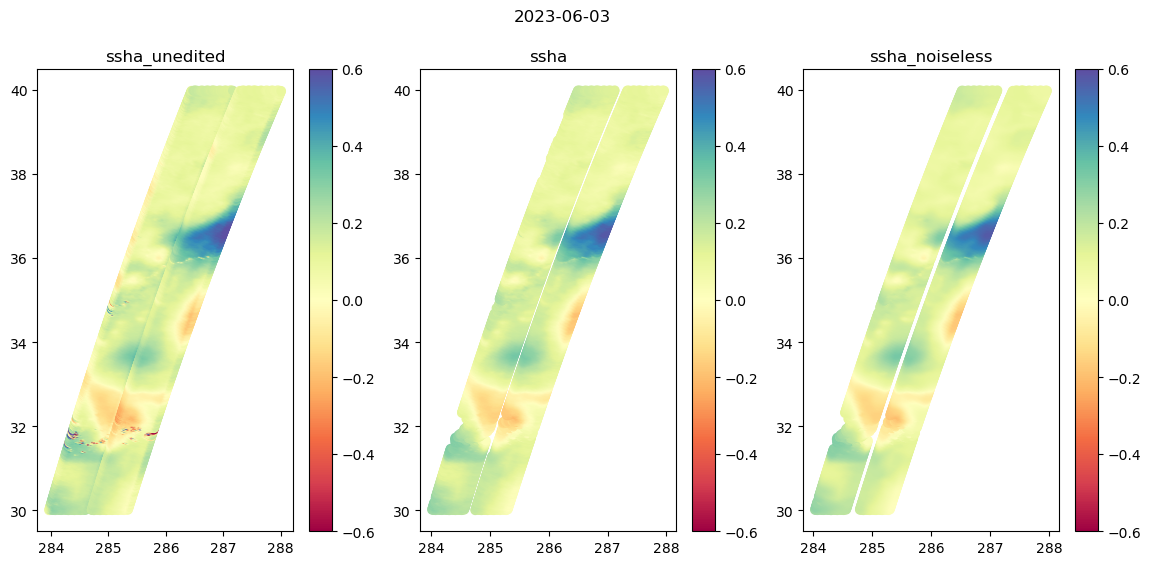

2023-06-04


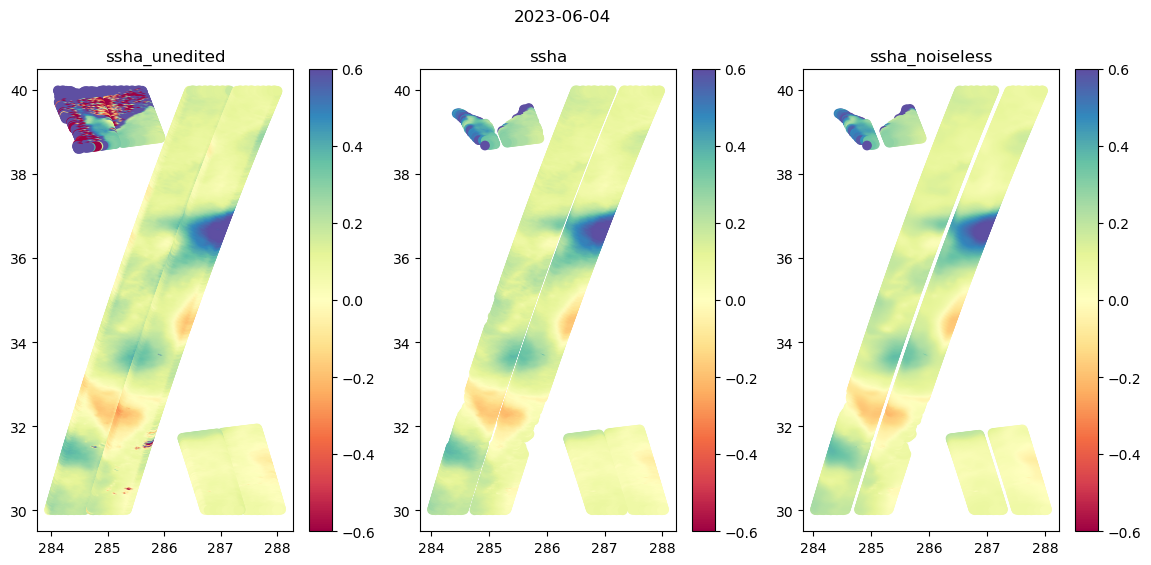

2023-06-05
2023-06-06


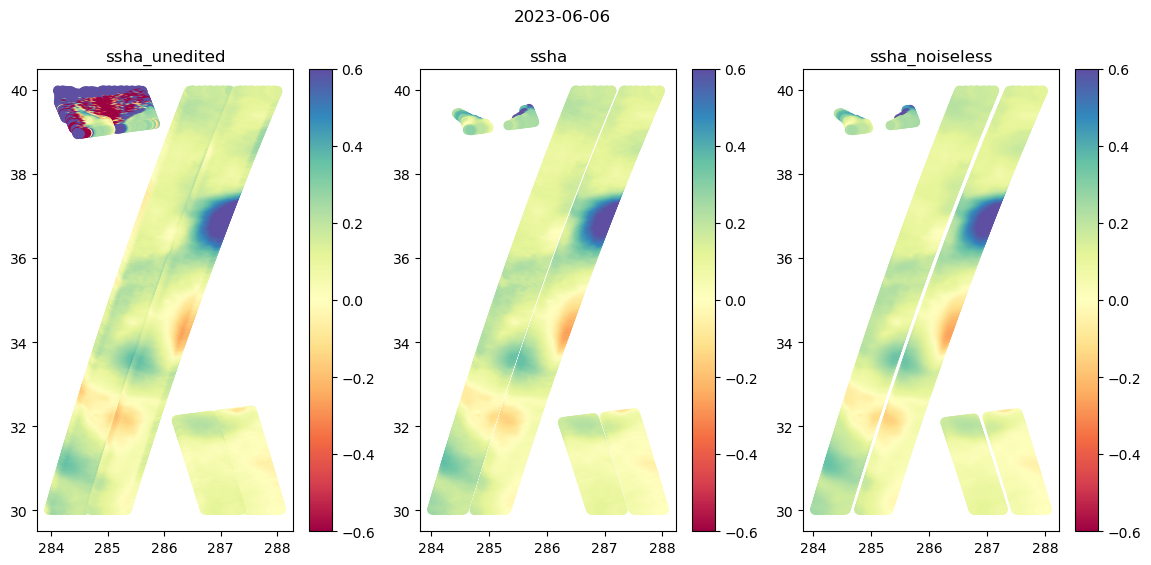

2023-06-07


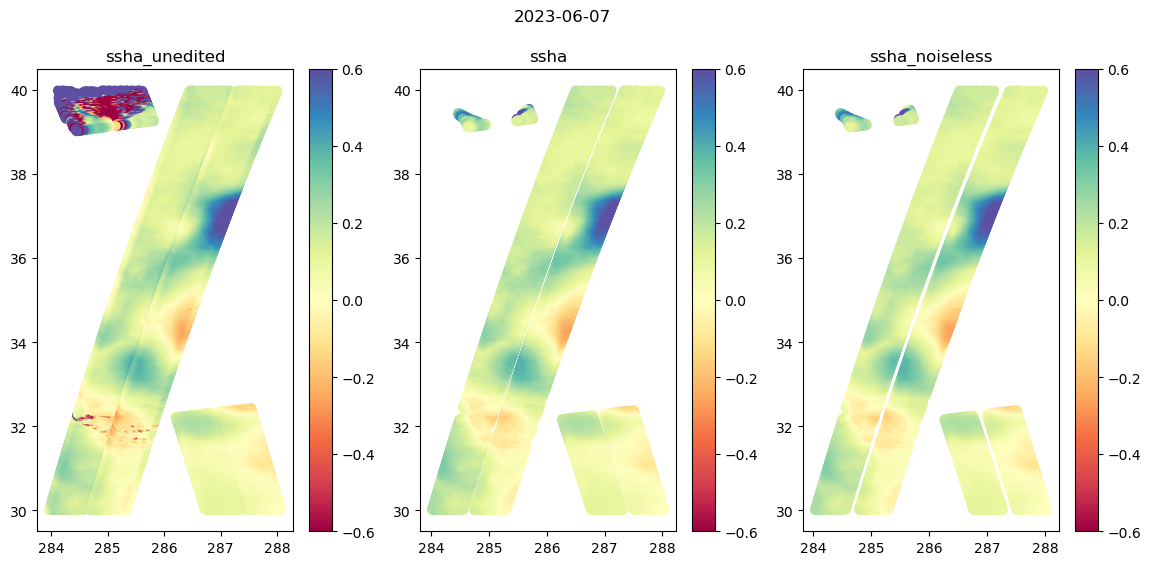

2023-06-08


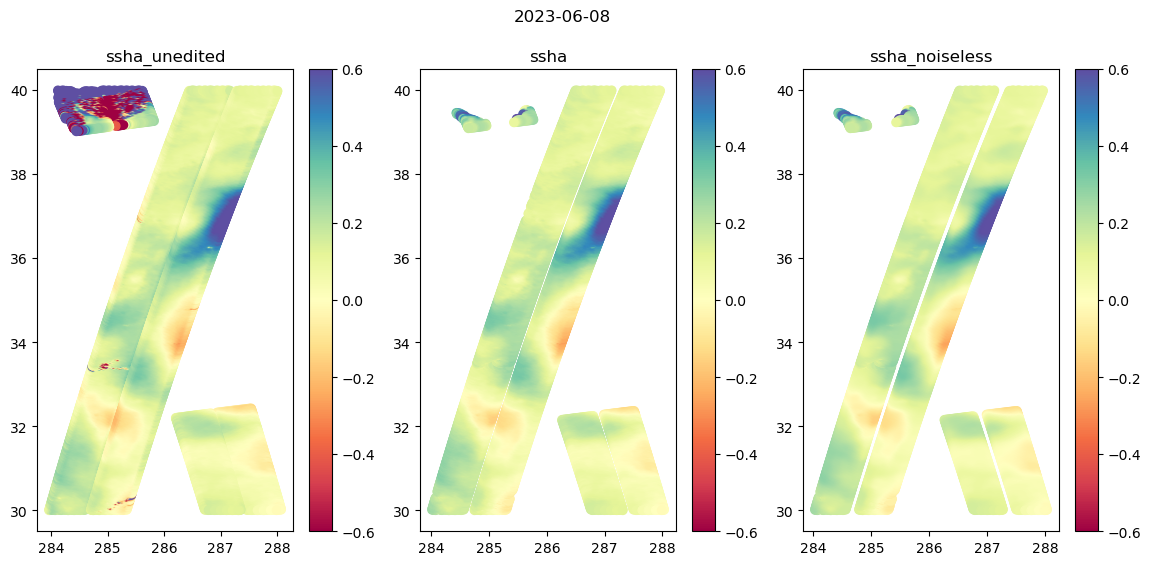

2023-06-09


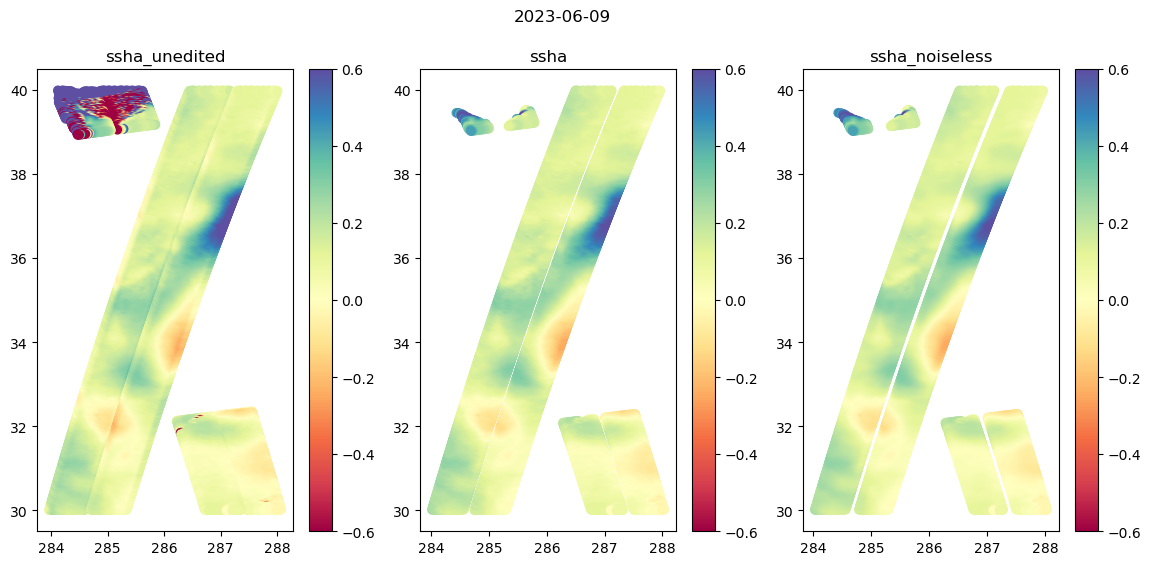

2023-06-10


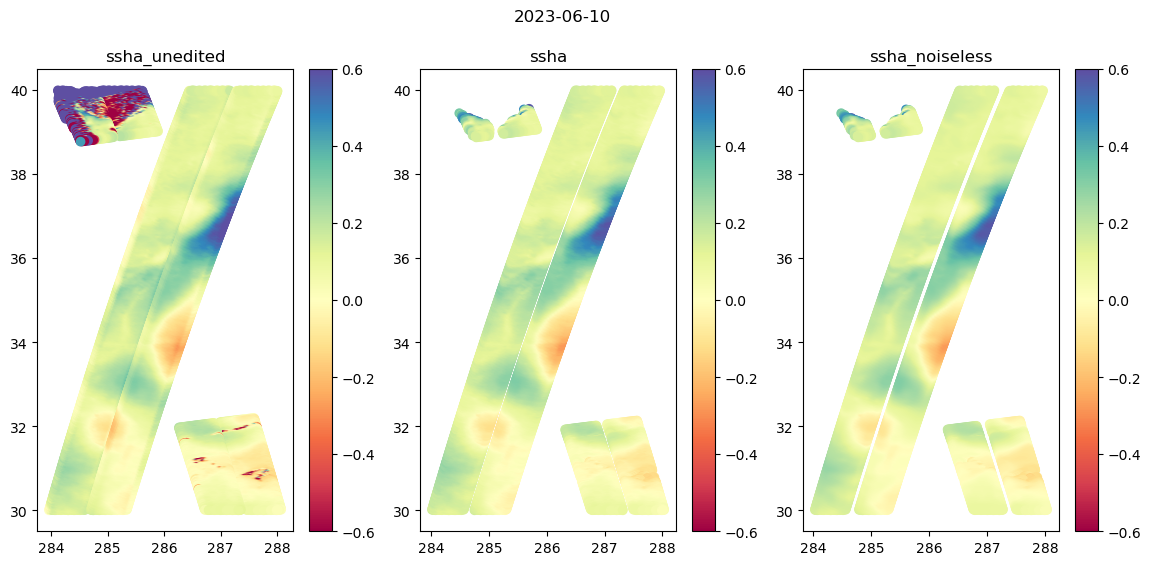

2023-06-11


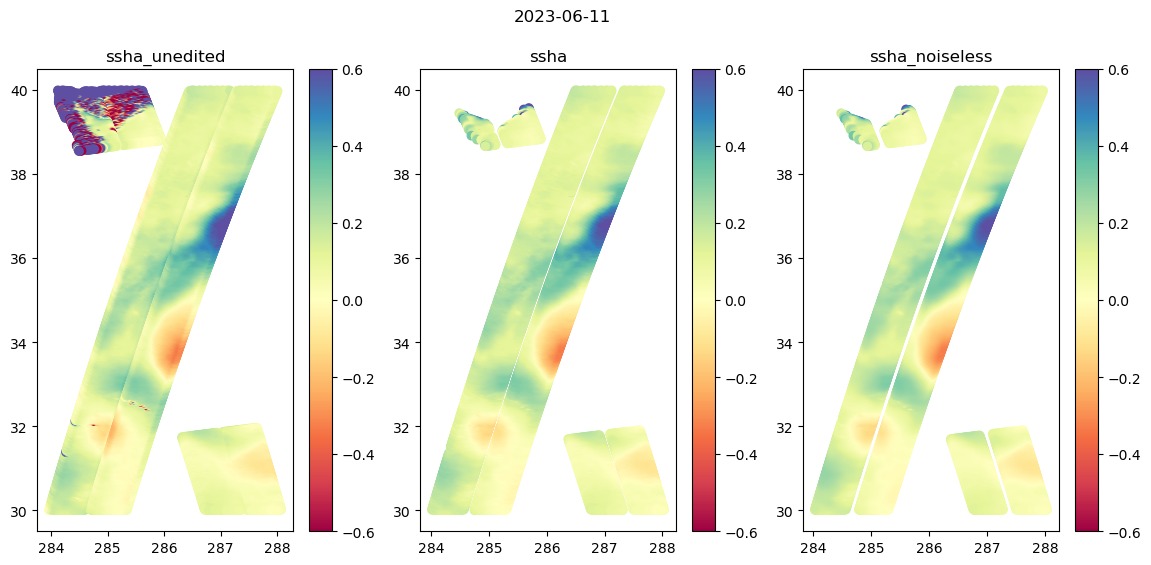

2023-06-12


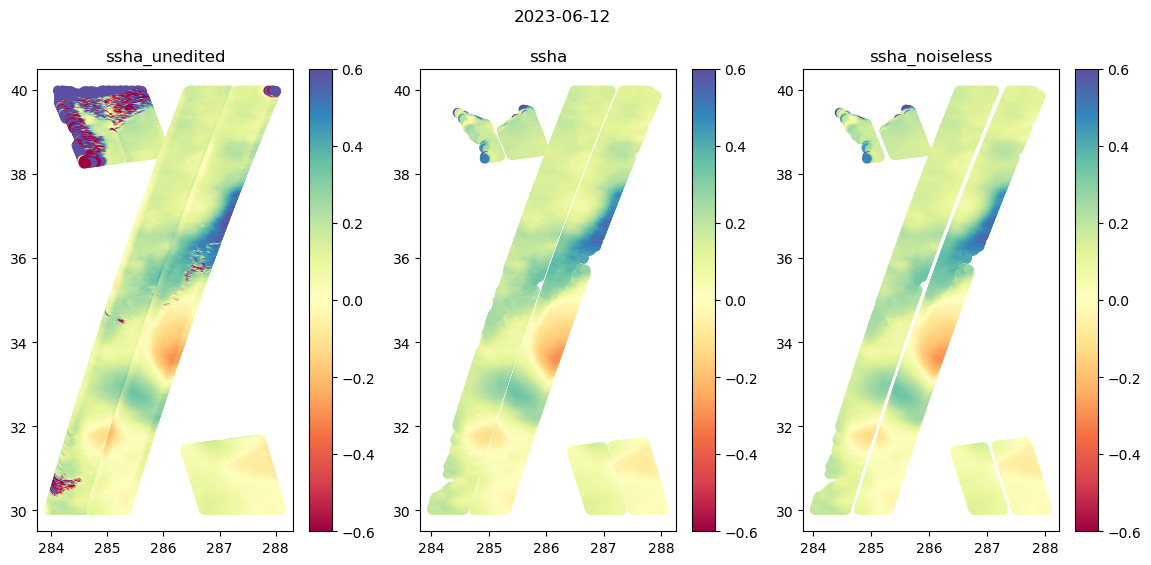

2023-06-13


KeyboardInterrupt: 

In [111]:
time0 = np.datetime64('2023-06-03')
ndays = 38

for idays in range(ndays):
    
    time1 = time0 + np.timedelta64(1,'D')
    
    print(time0)
    
    ds_passes_now=ds_passes.where(ds_passes.time>time0,drop=True)
    ds_passes_now=ds_passes_now.where(ds_passes_now.time<time1,drop=True) 
    
    if ds_passes_now.num_lines.size != 0:
        plt.figure(figsize=(14,6))

        plt.suptitle(time0)

        plt.subplot(131)
        plt.title('ssha_unedited')
        plt.scatter(ds_passes_now.longitude[:,:34],ds_passes_now.latitude[:,:34],c=ds_passes_now.ssha_unedited[:,:34],cmap='Spectral', vmin=-0.6, vmax=0.6) 
        plt.scatter(ds_passes_now.longitude[:,35:],ds_passes_now.latitude[:,35:],c=ds_passes_now.ssha_unedited[:,35:],cmap='Spectral', vmin=-0.6, vmax=0.6)
        plt.colorbar()

        plt.subplot(132)
        plt.title('ssha')
        plt.scatter(ds_passes_now.longitude[:,:34],ds_passes_now.latitude[:,:34],c=ds_passes_now.ssha[:,:34],cmap='Spectral', vmin=-0.6, vmax=0.6) 
        plt.scatter(ds_passes_now.longitude[:,35:],ds_passes_now.latitude[:,35:],c=ds_passes_now.ssha[:,35:],cmap='Spectral', vmin=-0.6, vmax=0.6)
        plt.colorbar()

        plt.subplot(133)
        plt.title('ssha_noiseless')
        plt.scatter(ds_passes_now.longitude[:,:34],ds_passes_now.latitude[:,:34],c=ds_passes_now.ssha_noiseless[:,:34],cmap='Spectral', vmin=-0.6, vmax=0.6) 
        plt.scatter(ds_passes_now.longitude[:,35:],ds_passes_now.latitude[:,35:],c=ds_passes_now.ssha_noiseless[:,35:],cmap='Spectral', vmin=-0.6, vmax=0.6)
        plt.colorbar()

        plt.show()
    
    time0 += np.timedelta64(1,'D')

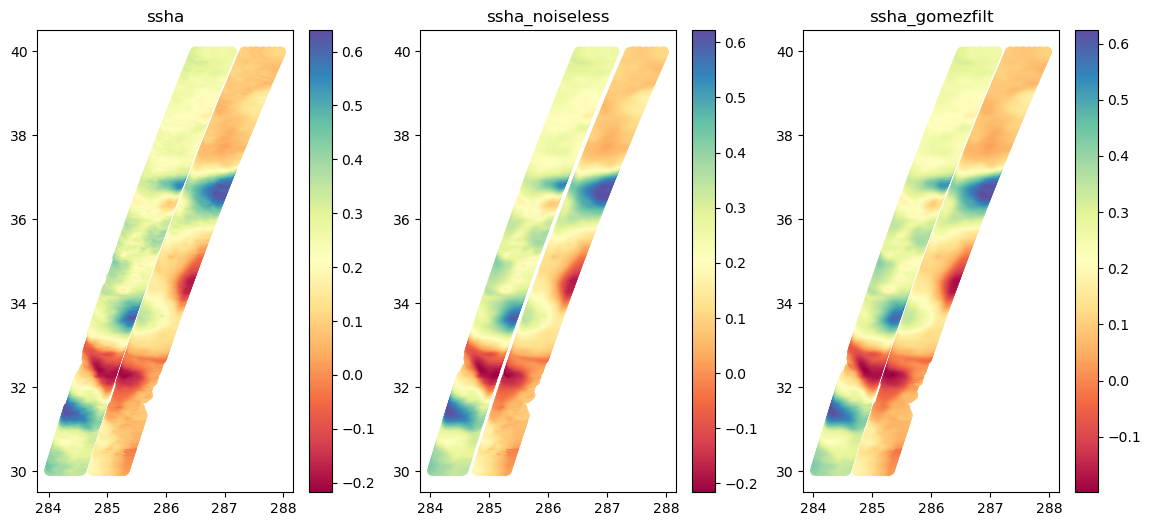

In [9]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.title('ssha')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],cmap='Spectral',c=ds_SWOT.ssha[:,:34]) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],cmap='Spectral',c=ds_SWOT.ssha[:,35:])
plt.colorbar()

plt.subplot(132)
plt.title('ssha_noiseless')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],cmap='Spectral',c=ds_SWOT.ssha_noiseless[:,:34]) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],cmap='Spectral',c=ds_SWOT.ssha_noiseless[:,35:])
plt.colorbar()

plt.subplot(133)
plt.title('ssha_gomezfilt')
plt.scatter(ds_SWOT_corrected.longitude[:,:34],ds_SWOT_corrected.latitude[:,:34],cmap='Spectral',c=ds_SWOT_corrected.ssha_gomezfilt[:,:34]) 
plt.scatter(ds_SWOT_corrected.longitude[:,35:],ds_SWOT_corrected.latitude[:,35:],cmap='Spectral',c=ds_SWOT_corrected.ssha_gomezfilt[:,35:])
plt.colorbar()

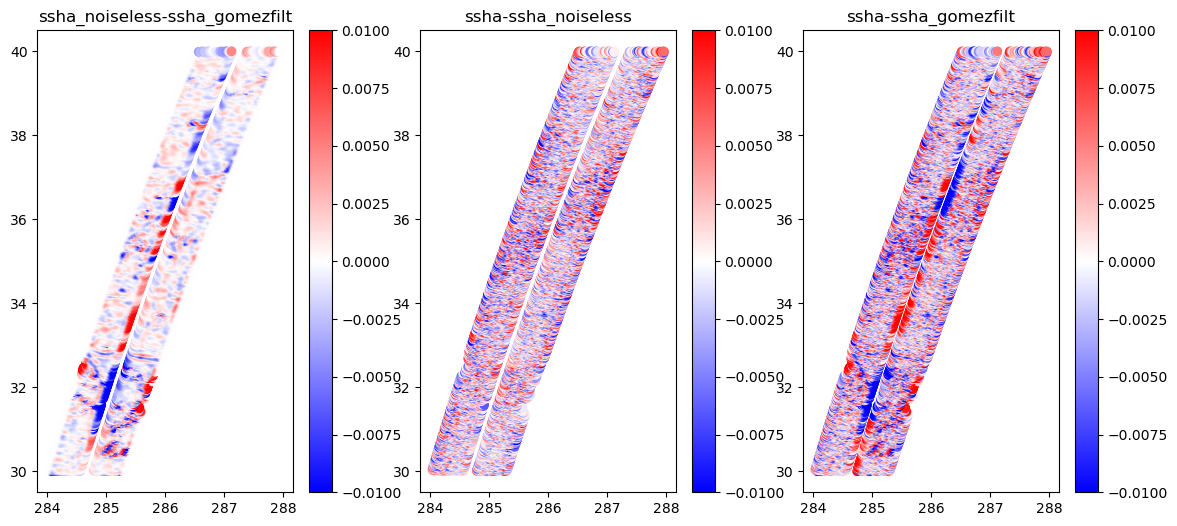

In [10]:
plt.figure(figsize=(14,6))


plt.subplot(131)
plt.title('ssha_noiseless-ssha_gomezfilt')
plt.scatter(ds_SWOT_corrected.longitude[:,:34],ds_SWOT_corrected.latitude[:,:34],c=ds_SWOT.ssha_noiseless[:,:34]-ds_SWOT_corrected.ssha_gomezfilt[:,:34],cmap='bwr',vmin=-0.01,vmax=0.01) 
plt.scatter(ds_SWOT_corrected.longitude[:,35:],ds_SWOT_corrected.latitude[:,35:],c=ds_SWOT.ssha_noiseless[:,35:]-ds_SWOT_corrected.ssha_gomezfilt[:,35:],cmap='bwr',vmin=-0.01,vmax=0.01)
plt.colorbar() 

plt.subplot(132)
plt.title('ssha-ssha_noiseless')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=ds_SWOT.ssha[:,:34]-ds_SWOT.ssha_noiseless[:,:34],cmap='bwr',vmin=-0.01,vmax=0.01) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=ds_SWOT.ssha[:,35:]-ds_SWOT.ssha_noiseless[:,35:],cmap='bwr',vmin=-0.01,vmax=0.01)
plt.colorbar()

plt.subplot(133)
plt.title('ssha-ssha_gomezfilt')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=ds_SWOT.ssha[:,:34]-ds_SWOT_corrected.ssha_gomezfilt[:,:34],cmap='bwr',vmin=-0.01,vmax=0.01) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=ds_SWOT.ssha[:,35:]-ds_SWOT_corrected.ssha_gomezfilt[:,35:],cmap='bwr',vmin=-0.01,vmax=0.01)
plt.colorbar()


In [11]:
def deriv1and2(h):
    gradx_h = gradx(h)
    grady_h = grady(h)
    # gradx_h = np.ma.array(gradx_h, mask = h_derivs.mask, fill_value = 1e9 )
    # grady_h = np.ma.array(grady_h, mask = h_derivs.mask, fill_value = 1e9 )
    grad_h  = gradx_h**2 + grady_h**2

    lap_h = laplacian(h)
    #lap_h = np.ma.array(lap_h, mask = h_derivs.mask, fill_value = 1e9 )

    gradxlap_h = gradx(lap_h)
    gradylap_h = grady(lap_h)
    # gradxlap_h = np.ma.array(gradxlap_h, mask = h_derivs.mask, fill_value = 1e9 )
    # gradylap_h = np.ma.array(gradylap_h, mask = h_derivs.mask, fill_value = 1e9 )
    gradlap_h =  gradxlap_h**2 + gradylap_h**2
    
    return grad_h, lap_h

def gradx(I): 
    """
    Calculates the gradient in the x-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last row is left as 0s.
    """
    
    m, n = I.shape
    M = np.ma.zeros([m,n])

    M[0:-1,:] = np.ma.subtract(I[1::,:], I[0:-1,:])
    return M


def grady(I): 
    """
    Calculates the gradient in the y-direction of an image I and gives as output M.
    In order to keep the size of the initial image the last column is left as 0s.
    """
    
    m, n = I.shape
    M = np.ma.zeros([m,n])
    M[:,0:-1] =  np.ma.subtract(I[:,1::], I[:,0:-1])
    return M


def div(px, py): 
    """
    Calculates the divergence of a 2D field. 
    For the specific application of image denoising, the calculation follows Chambolle (REF)
    ## BELOW, TO BE CLARIFIED
    The x component of M (Mx) first row is = to the first row of px.
    The x component of M (Mx) last row is = to - the before last row of px. (last one = 0)
    The y component of M (My) first column is = to the first column of py.
    The y component of M (My) last column is = to - the before last column of py. (last one = 0)
    ??#(de sorte que div=-(grad)^*)
    Parameters: two 2D ndarray
    Returns: 2D ndarray
    """
    m, n = px.shape
    M = np.ma.zeros([m,n])
    Mx = np.ma.zeros([m,n])
    My = np.ma.zeros([m,n])
 
    Mx[1:m-1, :] = px[1:m-1, :] - px[0:m-2, :]
    Mx[0, :] = px[0, :]
    Mx[m-1, :] = -px[m-2, :]

    My[:, 1:n-1] = py[:, 1:n-1] - py[:, 0:n-2]
    My[:, 0] = py[:,0]
    My[:, n-1] = -py[:, n-2]
     
    M = Mx + My;
    return M


def laplacian(u):
    """
    Calculates laplacian using the divergence and gradient functions defined in the module.
    Parameter: 2D ndarray
    Returns: 2D ndarray
    """
    Ml = div(gradx(u), grady(u));
    return Ml

In [12]:
grad_ssha, lap_ssha = deriv1and2(ds_SWOT.ssha)
grad_ssha_noiseless, lap_ssha_noiseless = deriv1and2(ds_SWOT.ssha_noiseless)
grad_ssha_gomezfilt, lap_ssha_gomezfilt = deriv1and2(ds_SWOT_corrected.ssha_gomezfilt)

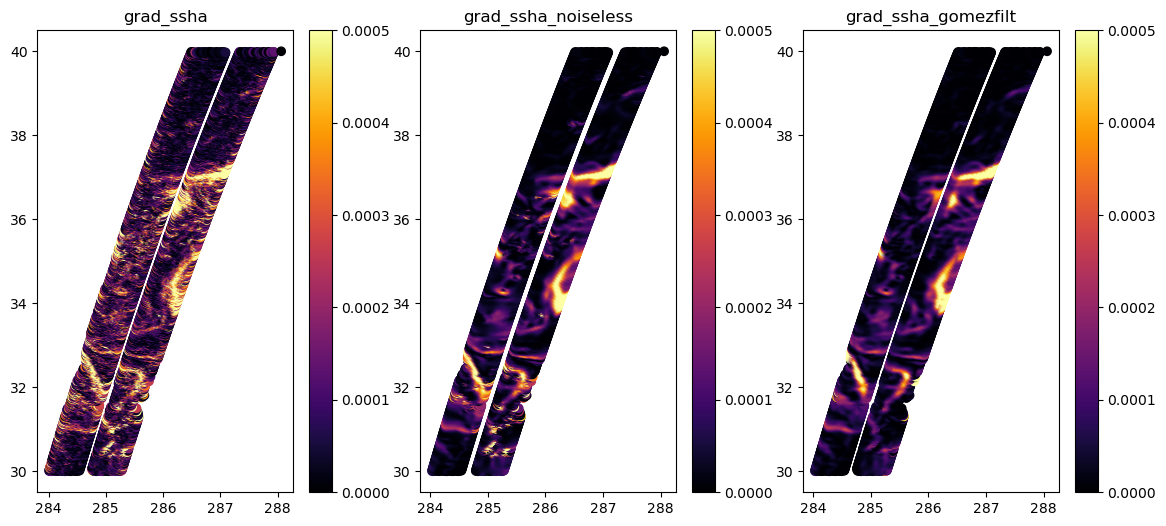

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.title('grad_ssha')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=grad_ssha[:,:34],cmap='inferno',vmin=0,vmax=0.0005) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=grad_ssha[:,35:],cmap='inferno',vmin=0,vmax=0.0005)
plt.colorbar()

plt.subplot(132)
plt.title('grad_ssha_noiseless')
plt.scatter(ds_SWOT_corrected.longitude[:,:34],ds_SWOT_corrected.latitude[:,:34],c=grad_ssha_noiseless[:,:34],cmap='inferno',vmin=0,vmax=0.0005) 
plt.scatter(ds_SWOT_corrected.longitude[:,35:],ds_SWOT_corrected.latitude[:,35:],c=grad_ssha_noiseless[:,35:],cmap='inferno',vmin=0,vmax=0.0005)
plt.colorbar() 

plt.subplot(133)
plt.title('grad_ssha_gomezfilt')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=grad_ssha_gomezfilt[:,:34],cmap='inferno',vmin=0,vmax=0.0005) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=grad_ssha_gomezfilt[:,35:],cmap='inferno',vmin=0,vmax=0.0005)
plt.colorbar()


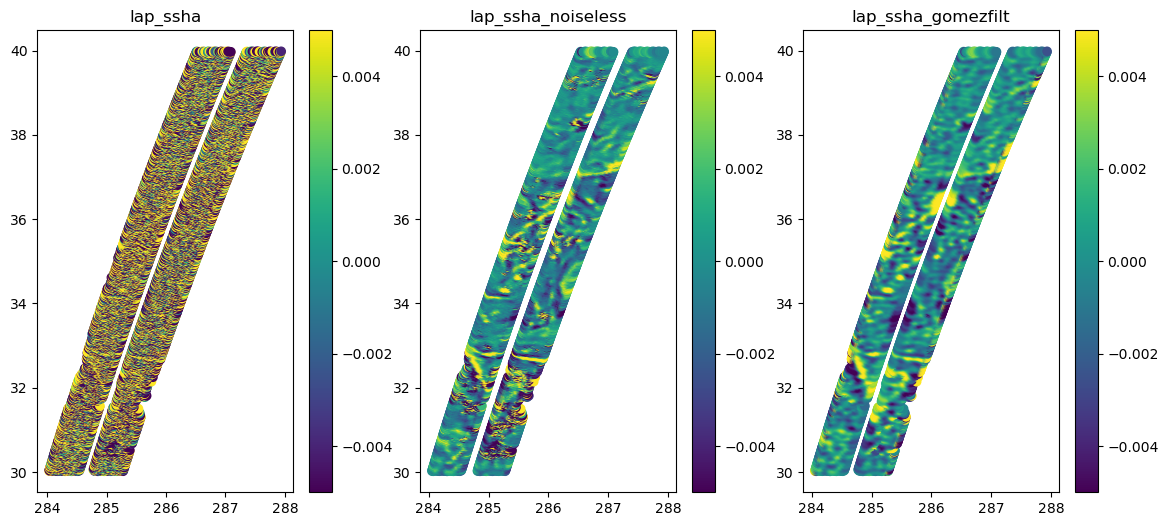

In [14]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.title('lap_ssha')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=lap_ssha[:,:34],vmin=-0.005,vmax=0.005) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=lap_ssha[:,35:],vmin=-0.005,vmax=0.005)
plt.colorbar()

plt.subplot(132)
plt.title('lap_ssha_noiseless')
plt.scatter(ds_SWOT_corrected.longitude[:,:34],ds_SWOT_corrected.latitude[:,:34],c=lap_ssha_noiseless[:,:34],vmin=-0.005,vmax=0.005) 
plt.scatter(ds_SWOT_corrected.longitude[:,35:],ds_SWOT_corrected.latitude[:,35:],c=lap_ssha_noiseless[:,35:],vmin=-0.005,vmax=0.005)
plt.colorbar() 

plt.subplot(133)
plt.title('lap_ssha_gomezfilt')
plt.scatter(ds_SWOT.longitude[:,:34],ds_SWOT.latitude[:,:34],c=lap_ssha_gomezfilt[:,:34],vmin=-0.005,vmax=0.005) 
plt.scatter(ds_SWOT.longitude[:,35:],ds_SWOT.latitude[:,35:],c=lap_ssha_gomezfilt[:,35:],vmin=-0.005,vmax=0.005)
plt.colorbar()


TypeError: movie.<locals>._save_single_frame() missing 1 required positional argument: 'time0'

In [15]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
path_input = '../Data/DC_SWOTcalib_GS/dc_SWOTcalibGS_inputs/dc_SWOTcalibGS_input_pass' 

In [ ]:

dc_SWOT_input = ds_SWOT.rename({'swot_with_error':'ssh_err'})
dc_SWOT_input = dc_SWOT_input.rename({'swot_without_error':'ssh_true'})
 

In [ ]:
ipass_bef = 0
for ipass in ds_SWOT.contiguous_chunk.values:
    if int(ipass) != ipass_bef:
        print(ipass)
        
        ipass_bef = int(ipass)
        
        dc_SWOTpass_input=dc_SWOT_input.where(dc_SWOT_input.contiguous_chunk==int(ipass),drop=True) 
        
        dc_SWOTpass_input = dc_SWOTpass_input.drop({'contiguous_chunk'}) 
         
        
        dc_SWOTpass_input.to_netcdf(path_input+np.str(int(ipass)).zfill(2)+'.nc') 
        
        

In [ ]:
dc_SWOT_input

In [ ]:
lat = list()
for i in range(np.shape(dc_SWOT_input.lat)[0]):
    indlat = np.arange(0,52)
    indlat[26:] += 10

    mylat=dc_SWOT_input.lat[i,:].values

    from scipy import interpolate
    f= interpolate.interp1d(indlat, mylat)

    newindlat =  np.arange(61) 

    lat.append(f(newindlat))

In [ ]:
lon = list()
for i in range(np.shape(dc_SWOT_input.lon)[0]):
    indlon = np.arange(0,52)
    indlon[26:] += 10

    mylon=dc_SWOT_input.lon[i,:].values

    from scipy import interpolate
    f= interpolate.interp1d(indlon, mylon)

    newindlon =  np.arange(61) 

    lon.append(f(newindlon))

In [ ]:
xac = list()
for i in range(np.shape(dc_SWOT_input.x_ac)[0]): 

    myxac=np.arange(-60,61,2)

    xac.append(myxac)

In [ ]:
ssh_true = np.zeros([np.shape(dc_SWOT_input.ssh_true)[0],61])

ssh_true[:] = np.nan

ssh_true[:,:26] = dc_SWOT_input.ssh_true.values[:,:26]
ssh_true[:,35:] = dc_SWOT_input.ssh_true.values[:,26:]

In [ ]:
ssh_err = np.zeros([np.shape(dc_SWOT_input.ssh_err)[0],61])

ssh_err[:] = np.nan

ssh_err[:,:26] = dc_SWOT_input.ssh_err.values[:,:26]
ssh_err[:,35:] = dc_SWOT_input.ssh_err.values[:,26:]

In [ ]:
lat = np.array(lat)
lon = np.array(lon)
ssh_true = np.array(ssh_true)
ssh_err = np.array(ssh_err)
xac = np.array(xac) 

In [ ]:
new_dc_SWOT = dc_SWOT_input

In [ ]:
new_dc_SWOT = new_dc_SWOT.drop({'x_ac','lat','lon','ssh_true','ssh_err'})

In [ ]:
new_dc_SWOT = xr.Dataset(
     {
         "lat": (("time", "nC"),lat,dc_SWOT_input.lat.attrs),
         "lon": (("time", "nC"), lon,dc_SWOT_input.lon.attrs),
         "lat_nadir": (("time"), dc_SWOT_input.lat_nadir.values,dc_SWOT_input.lat_nadir.attrs),
         "lon_nadir": (("time"), dc_SWOT_input.lon_nadir.values,dc_SWOT_input.lon_nadir.attrs),
         "x_ac": (("time","nC"), xac,dc_SWOT_input.x_ac.attrs),
         "x_al": (("time"), dc_SWOT_input.x_al.values,dc_SWOT_input.x_al.attrs),
         "ssh_true": (("time", "nC"), ssh_true,dc_SWOT_input.ssh_true.attrs),
         "ssh_err": (("time", "nC"), ssh_err,dc_SWOT_input.ssh_err.attrs),
         "contiguous_chunk":(("time"),dc_SWOT_input.contiguous_chunk.values,dc_SWOT_input.contiguous_chunk.attrs)
     },
     coords={"time": dc_SWOT_input.time, "nC": np.arange(61)},
     attrs=dc_SWOT_input.attrs,
 )

In [ ]:
new_dc_SWOT

In [ ]:
ipass_bef = 0
for ipass in ds_SWOT.contiguous_chunk.values:
    if int(ipass) != ipass_bef:
        print(ipass)
        
        ipass_bef = int(ipass)
        
        dc_SWOTpass_input=new_dc_SWOT.where(new_dc_SWOT.contiguous_chunk==int(ipass),drop=True) 
        
        dc_SWOTpass_input = dc_SWOTpass_input.drop({'contiguous_chunk'}) 
         
        
        dc_SWOTpass_input.to_netcdf(path_input+np.str(int(ipass)).zfill(2)+'.nc') 
        
        

In [ ]:
dc_SWOTpass_input

# Preping nadir data

In [ ]:
ls ../../DataChallenges_testing/DC_SSH_mapping/2020a_SSH_mapping_NATL60/dc_obs/

In [ ]:
path_output = '../Data/DC_SWOTcalib_GS/dc_SWOTcalibGS_nadirs/' 

# Retrieving real cryosat data

In [ ]:
ds_c2_real = xr.open_mfdataset('../Data/DC_SWOTcalib_GS/Real_C2_data/dt*', combine='nested', concat_dim='time')

In [ ]:
ds_c2_real

In [ ]:
ds_natl = xr.open_mfdataset('../../DataChallenges_testing/DC_SSH_mapping/2020a_SSH_mapping_NATL60/dc_ref/NATL60-CJM165_GULFSTREAM_y201*', combine='nested', concat_dim='time')

In [ ]:
time_min = np.datetime64('2012-10-22')
time_max = np.datetime64('2012-12-02')

In [ ]:

ds_natl = ds_natl.sel({'time':slice(time_min,time_max)})

In [ ]:
lon_min = np.min(ds_natl.lon.values)+360
lon_max = np.max(ds_natl.lon.values)+360
lat_min = np.min(ds_natl.lat.values)
lat_max = np.max(ds_natl.lat.values)

In [ ]:
ds_c2_real = ds_c2_real.sel({'time':slice(time_min,time_max)})

In [ ]:
plt.scatter(ds_c2_real.longitude,ds_c2_real.latitude,c=ds_c2_real.sla_unfiltered)

In [ ]:
ds_c2_real.where(ds_c2_real.longitude<lon_max,drop=True).longitude.values

In [ ]:
.where(a.currency=='EUR', drop=True)

In [ ]:
ds_c2_real = ds_c2_real.where(ds_c2_real.longitude<lon_max,drop=True)
ds_c2_real = ds_c2_real.where(ds_c2_real.longitude>lon_min,drop=True)

In [ ]:
ds_c2_real = ds_c2_real.where(ds_c2_real.latitude<lat_max,drop=True)
ds_c2_real = ds_c2_real.where(ds_c2_real.latitude>lat_min,drop=True)

In [ ]:
ds_c2_real

In [ ]:
from scipy import interpolate

In [ ]:
%%time 

ssh_c2_artif = list()
time_c2_artif = list()
lon_c2_artif = list()
lat_c2_artif = list()
iter = 0
for itime in ds_natl.time.values:
    
    print(itime)
    
    ssh_natl = ds_natl.sel({'time':itime}).sossheig
    ssh_c2 = ds_c2_real.sel({'time':slice(itime-np.timedelta64(30,'m'),itime+np.timedelta64(30,'m'))})
    
    nlon, nlat = np.meshgrid(np.array(ds_natl.lon+360),np.array(ds_natl.lat))

    if np.shape(ssh_c2.time)[0] != 0: 
    
        var_out = interpolate.griddata((np.array(nlon).ravel(),np.array(nlat).ravel()),
                   np.array(ssh_natl).ravel(),
                   (ssh_c2.longitude.values,ssh_c2.latitude.values)) 
        
        if iter ==0:
            ssh_c2_artif = var_out
            time_c2_artif = np.array(ssh_c2.time.values)
            lon_c2_artif = np.array(ssh_c2.longitude.values)
            lat_c2_artif = np.array(ssh_c2.latitude.values)
        else:  
            ssh_c2_artif = np.hstack((ssh_c2_artif,var_out))
            time_c2_artif = np.hstack((time_c2_artif,np.array(ssh_c2.time.values)))
            lon_c2_artif = np.hstack((lon_c2_artif,np.array(ssh_c2.longitude.values)))
            lat_c2_artif = np.hstack((lat_c2_artif,np.array(ssh_c2.latitude.values)))
          
        iter += 1

In [ ]:
ds_c2_real['ssh_model'] = ('time',ssh_c2_artif) 

In [ ]:
ds_c2_real = ds_c2_real.drop('dac')
ds_c2_real = ds_c2_real.drop('sla_unfiltered')
ds_c2_real = ds_c2_real.drop('sla_filtered')
ds_c2_real = ds_c2_real.drop('ocean_tide')
ds_c2_real = ds_c2_real.drop('internal_tide')
ds_c2_real = ds_c2_real.drop('lwe')
ds_c2_real = ds_c2_real.drop('mdt')
ds_c2_real = ds_c2_real.drop('tpa_correction')

In [ ]:
ds_c2_real = ds_c2_real.rename_vars({'longitude':'lon'})
ds_c2_real = ds_c2_real.rename_vars({'latitude':'lat'})

In [ ]:
ds_c2_real 

In [ ]:
ds_c2_real.to_netcdf('../Data/DC_SWOTcalib_GS/dc_SWOTcalibGS_nadirs/dc_SWOTcalibGS_cryosat.nc')

In [ ]:
plt.scatter(ds_c2_real.lon,ds_c2_real.lat,c=ds_c2_real.ssh_model)